# Import functions

In [141]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed
np.random.seed(1)
torch.manual_seed(1)

# HJ PDE Experiment: 1D Quadratic term with initial data  
$J(x) = min(\frac{1}{2t\sigma_{1}}(x-\mu_{1})^{2}, \frac{1}{2\sigma_{2}}(x-\mu_{2}^{2})^{2})$

# Parameters of the HJ PDE

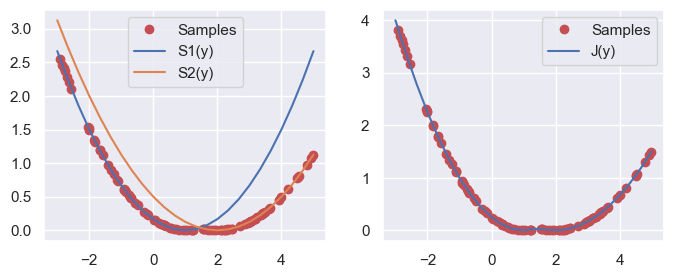

In [142]:
# We consider here the non-convex optimization problem:
# S(y) = min_{x \in \R} \frac{1}{2}(x-y)^{2} + J(x),
# where J(x) = min(\frac{1}{2\sigma_{1}}(x-\mu_{1})^{2}, \frac{1}{2\sigma_{2}}(x-\mu_{2}^{2})^{2}).

# This problem admits the explicit solution
# S(y) = min_{i \in \{1,\dots,m}} { (1/2(1+sigma_i))*||mu_i - y||^{2}_{2} }

# We'll train a Learned Proximal Network to learn the solution
# of this problem from a set of K samples (yk,S(yk))_{k=1}^{K}.

# Parameters of the HJ PDE
mu1 = 1
mu2 = 2
sigma1 = 2
sigma2 = 3

# Number of samples and range [a,b] from which to sample and plot
K = 100
b = 5
a = -3 


# True solution S(y,t)
def compute_true_minplus_solution(y,mu1,sigma1,mu2,sigma2):
    """
    Inputs:
        y:              ``Spatial" variable of the HJ solution
        mu1,mu2:        Parameters in the quadratic terms (means)
        sigma1,sigma2:  Parameters in the quadratic terms (standard deviations)

    Outputs:      
        Sy:             Solution to the minplus HJ PDE
    """

    Sy = 0.5*torch.minimum(torch.pow(y-mu1,2)/(1+sigma1),torch.pow(y-mu2,2)/(1+sigma2))
    return Sy

# Initial data J(y)
def compute_initial_data_minplus(y,mu1,sigma1,mu2,sigma2):
    """
    Inputs:
        y:              ``Spatial" variable of the HJ solution
        mu1,mu2:        Parameters in the quadratic terms (means)
        sigma1,sigma2:  Parameters in the quadratic terms (standard deviations)

    Outputs:      
        Jy:             Value of the initial data of the minplus HJ PDE
    """

    Jy = 0.5*torch.minimum(torch.pow(y - mu1,2)/sigma1, torch.pow(y-mu2,2)/sigma2)
    return Jy

    
# Generate K samples uniformly from [-3,5]
ysamples = a + (b-a)*torch.rand(size=(K,1)) 
Sysamples = compute_true_minplus_solution(ysamples,mu1,sigma1,mu2,sigma2)
Jysamples = compute_initial_data_minplus(ysamples,mu1,sigma1,mu2,sigma2)

# Compute the true solution S(y)
ytrue = np.linspace(a,b,25)
Sytrue = 0.5*np.minimum(pow(ytrue-mu1,2)/(1+sigma1),pow(ytrue-mu2,2)/(1+sigma2))

# Compute the subsolutions S_{i}(y,t), where S(y,t) = min_{i}S_{i}(y,t)
Sy1 = 0.5*pow(ytrue-mu1,2)/(1+sigma1)
Sy2 = 0.5*pow(ytrue-mu2,2)/(1+sigma2)

plt.subplot(1,2,1)
plt.plot(ysamples.numpy(),Sysamples.numpy(),'o', color='r',label="Samples");
plt.plot(ytrue,Sy1,'-',label="S1(y)");
plt.plot(ytrue,Sy2,'-',label="S2(y)");
plt.legend()

plt.subplot(1,2,2)
plt.plot(ysamples.numpy(),Jysamples.numpy(),'o', color='r', label="Samples")
plt.plot(ytrue,0.5*np.minimum(pow(ytrue - mu1,2)/sigma1, pow(ytrue-mu2,2)/sigma2),'-',label="J(y)")
plt.legend()


# Model parameters

In [143]:
beta = 10       # beta of softplus
hidden = 100     # number of hidden units
layers = 8      # number of layers

# Default values
# beta = 10       # beta of softplus
# hidden = 50     # number of hidden units
# layers = 4      # number of layers

# Create a model
lpn_model = LPN(in_dim = 1, hidden=hidden, layers=layers, beta=beta).to(device)

print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 81802


# Plot function

In [144]:
# Plotting an LPN model
# function to plot learned prox, convex function, original function
def plot_all(model,ysamples,Sysamples,Jysamples):
    xi = np.linspace(a, b, 300)

    y = prox(xi, model)
    c = cvx(xi, model)
    ysamples = ysamples.detach().numpy()
    Sysamples = Sysamples.detach().numpy()
    Jysamples = Jysamples.detach().numpy()

    plt.rcParams["figure.figsize"] = (8, 3)

    # Learned proximal operator
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "--", ms=5, label="LPN")
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # Convex function
    # Note: The convex function is equal to 0.5*y^2 - t*S(y,t)
    plt.subplot(1, 3, 2)
    plt.plot(xi, c - c.min(), "--", ms=5, label="Cvx func -- LPN")
    plt.plot(ysamples, 0.5*pow(ysamples,2) - Sysamples, ".", label="Cvx func at samples -- True")
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # Initial data J(y)
    plt.subplot(1, 3, 3)
    #plt.plot(xi, compute_initial_data_minplus(xi), "--", label="Initial data J(y)")
    plt.plot(ysamples, Jysamples,".", label="Initial data J(y) -- True")
    plt.grid("on")
    plt.legend()
    plt.title("Initial data")

    # Solution to HJ PDE S(y,t)

    plt.tight_layout()

# Proximal matching loss

In [145]:
# Proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1

# Training function

In [146]:
# Defines what is a single iteration in the training of the LPN.xw

def single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss=None):
    input = ysamples
    target = 0.5*(torch.pow(ysamples,2)) - Sysamples
    
    out = lpn_model(input)

    if loss_type == 2:
        loss = (out - target).pow(2).sum() / K  # MSE loss
    elif loss_type == 1:
        loss = (out - target).abs().sum() / K  # MAE loss
    elif loss_type == 0:
        loss = exp_func(out - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    # if not i % 500:
    #     print("iteration", i, "loss", loss.item(), "loss_lstar", loss_lstar.item())

# Train

L2 loss

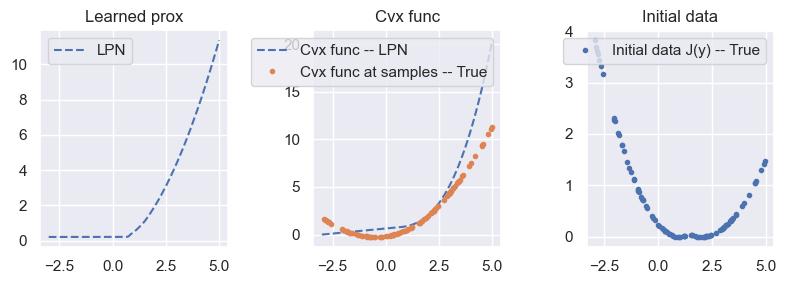

In [147]:
# Initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-4)
loss_type = 2


# Train for 10000 iterations
for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples)
# print(
#     "Values at [-3,-2,-1,0,1,2,3]:",
#     lpn_model(
#         torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
#     ).squeeze(1),
# )


L1 loss

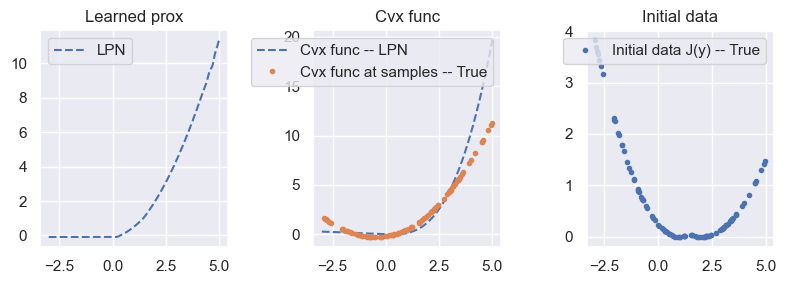

In [148]:
# Initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
loss_type = 1

# Train for 10000 iterations
for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples)

Proximal matching loss with gamma = 0.1

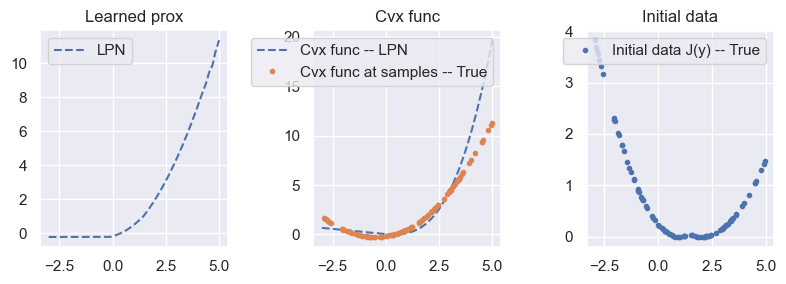

In [149]:
loss_type = 0
gamma_loss = 0.1

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples)

Proximal matching with gamma = 0.01

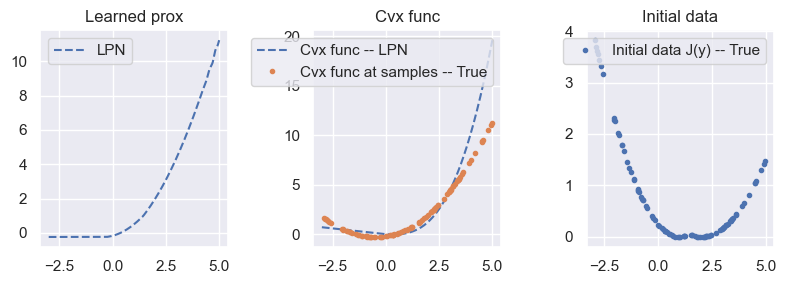

In [150]:
loss_type = 0
gamma_loss = 0.01

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples)